In [1]:
# load the model from the file "sbm3x3_pclam_roc_0.210_auc_0.860"
import torch
from torch_geometric.transforms import TwoHop

import sys
if '..' not in sys.path:
    sys.path.insert(0, '..')

from datasets.import_dataset import import_dataset
from utils.plotting import *
from trainer import Trainer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Using device:', device)
cpu = torch.device("cpu")

%load_ext autoreload
%autoreload 2


Using device: cuda




/home/user/Documents/danny/AAAI_pieclam/experiments/../trainer.py:302:::  
 starting optimization of piegam on reddit on device cuda

 configs_dict: 
{
    "clamiter_init": {
        "dim_feat": 30,
        "dim_attr": 64,
        "s_reg": 0.0,
        "l1_reg": 1,
        "T": 1,
        "hidden_dim": 64,
        "num_coupling_blocks": 32,
        "num_layers_mlp": 2
    },
    "feat_opt": {
        "lr": 3e-06,
        "n_iter": 500,
        "early_stop": 0
    },
    "prior_opt": {
        "n_iter": 1300,
        "lr": 2e-06,
        "noise_amp": 0.05,
        "weight_decay": 0.1,
        "early_stop": 0
    },
    "back_forth": {
        "n_back_forth": 3,
        "scheduler_step_size": 1,
        "scheduler_gamma": 0.5,
        "early_stop_fit": 0,
        "first_func_in_fit": "fit_feats"
    }
}


/home/user/Documents/danny/AAAI_pieclam/experiments/../clamiter.py:546:::  
in fit,
first_func_in_fit='fit_feats'
second_function_name='fit_prior'


/home/user/Documents/danny/AAAI_pi

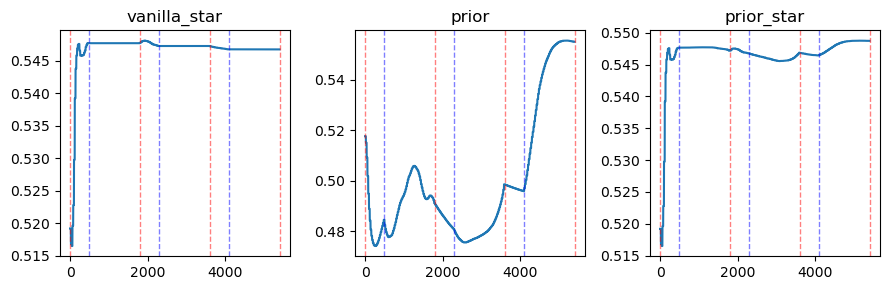



/home/user/Documents/danny/AAAI_pieclam/experiments/../clamiter.py:727:::  
in plot state, calling function is fit_feats


/home/user/Documents/danny/AAAI_pieclam/experiments/../utils/plotting.py:355:::  
calling_function_name= 'fit_feats' : iter 1/0


/home/user/Documents/danny/AAAI_pieclam/experiments/../clamiter.py:668:::  
fit end, no early stopping


/home/user/Documents/danny/AAAI_pieclam/experiments/../trainer.py:394:::  


FINISHED train model on params 





/home/user/Documents/danny/AAAI_pieclam/experiments/../trainer.py:302:::  
 starting optimization of iegam on reddit on device cuda

 configs_dict: 
{
    "clamiter_init": {
        "dim_feat": 24,
        "dim_attr": 40,
        "s_reg": 0.0,
        "l1_reg": 1,
        "T": 1,
        "hidden_dim": 64,
        "num_coupling_blocks": 32,
        "num_layers_mlp": 2
    },
    "feat_opt": {
        "lr": 1e-06,
        "n_iter": 2000,
        "early_stop": 0
    }
}


/home/user/Documents/danny/AAAI_pieclam/experiments/

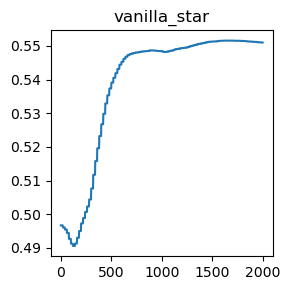



/home/user/Documents/danny/AAAI_pieclam/experiments/../clamiter.py:727:::  
in plot state, calling function is fit_feats


/home/user/Documents/danny/AAAI_pieclam/experiments/../utils/plotting.py:355:::  
calling_function_name= 'fit_feats' : iter 1/0


/home/user/Documents/danny/AAAI_pieclam/experiments/../trainer.py:302:::  
 starting optimization of pclam on reddit on device cuda

 configs_dict: 
{
    "clamiter_init": {
        "dim_feat": 18,
        "dim_attr": 40,
        "s_reg": 0.0,
        "l1_reg": 1,
        "T": 1,
        "hidden_dim": 64,
        "num_coupling_blocks": 32,
        "num_layers_mlp": 2
    },
    "feat_opt": {
        "lr": 3e-06,
        "n_iter": 500,
        "early_stop": 0
    },
    "prior_opt": {
        "n_iter": 10000,
        "lr": 0.0001,
        "noise_amp": 0.005,
        "weight_decay": 0.1,
        "early_stop": 0
    },
    "back_forth": {
        "n_back_forth": 20,
        "scheduler_step_size": 1,
        "scheduler_gamma": 0.5,
       

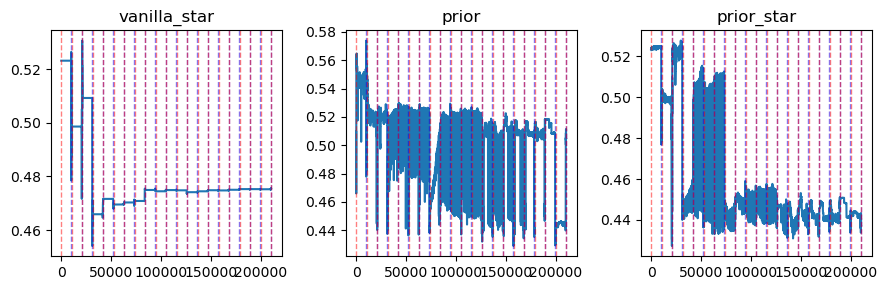



/home/user/Documents/danny/AAAI_pieclam/experiments/../clamiter.py:727:::  
in plot state, calling function is fit_feats


/home/user/Documents/danny/AAAI_pieclam/experiments/../utils/plotting.py:355:::  
calling_function_name= 'fit_feats' : iter 1/0


/home/user/Documents/danny/AAAI_pieclam/experiments/../clamiter.py:668:::  
fit end, no early stopping


/home/user/Documents/danny/AAAI_pieclam/experiments/../trainer.py:394:::  


FINISHED train model on params 





/home/user/Documents/danny/AAAI_pieclam/experiments/../trainer.py:302:::  
 starting optimization of bigclam on reddit on device cuda

 configs_dict: 
{
    "clamiter_init": {
        "dim_feat": 18,
        "dim_attr": 64,
        "s_reg": 0.0,
        "l1_reg": 1,
        "T": 1,
        "hidden_dim": 64,
        "num_coupling_blocks": 32,
        "num_layers_mlp": 2
    },
    "feat_opt": {
        "lr": 1e-06,
        "n_iter": 1700,
        "early_stop": 0
    }
}


/home/user/Documents/danny/AAAI_pieclam/experiment

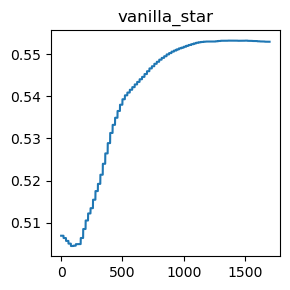



/home/user/Documents/danny/AAAI_pieclam/experiments/../clamiter.py:727:::  
in plot state, calling function is fit_feats


/home/user/Documents/danny/AAAI_pieclam/experiments/../utils/plotting.py:355:::  
calling_function_name= 'fit_feats' : iter 1/0


NameError: name 'fat_ds' is not defined

In [4]:

model_names = ['piegam', 'iegam', 'pclam', 'bigclam']
ds_names = ['reddit', 'elliptic', 'photo']

for ds_name in ds_names:    
    ds = import_dataset(ds_name)
    if ds_name in ['reddit', 'photo', 'elliptic']:
        fat_ds = TwoHop()(ds)
        fat_ds.edge_attr = torch.ones(fat_ds.edge_index.shape[1]).bool()
        ds_to_use = fat_ds
    
    ds_to_use = ds
    losseses = []
    acc_testses = []
    acc_valses = []
    
    for model_name in model_names:
        '''change some of the configs manually e.g. 
        config_triplets = [['feat_opt', 'n_iter', 1000], ['prior_opt, 'lr', 0.0001], ...]'''
        config_triplets = []

        trainer_anomaly = Trainer(
            model_name=model_name,
            device=device,
            dataset=ds_to_use.clone(),
            attr_opt=True,
            task='anomaly',
            mighty_configs_dict=False,
            config_triplets_to_change=config_triplets
        )

        losses, acc_test, acc_val = trainer_anomaly.train(
            init_type='small_gaus',
            init_feats=True,
            acc_every=20,
            plot_every=-1,
            verbose=False,
            verbose_in_funcs=False
        )
        losseses.append(losses)
        acc_testses.append(acc_test)
        acc_valses.append(acc_val)
        
        if trainer_anomaly.clamiter.prior is not None:
            del trainer_anomaly.clamiter.prior.model
        del trainer_anomaly.data
        torch.cuda.empty_cache()

    del ds
    del ds_to_use
    if ds_name in ['reddit', 'photo', 'elliptic']:
        del fat_ds
    torch.cuda.empty_cache()

